# All the imports I need

In [1]:
import pandas as pd
pd.options.display.float_format = "{:,.4f}".format
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16,9)
import scipy.stats as scp
import statsmodels.api as sm
import seaborn as sns
# import arch

# Reading Excel; Null values

In [2]:
class DataImport:
    
    def __init__(self, filename, add_ind=[]):
        self.xlsx = pd.ExcelFile(filename)
        self.add_ind = add_ind # Additional indices to try to 
        
        print(f"Read in <{filename}>.")
        self.sheets = []
        print('-'*20, "Reading Sheets ", '-'*20)
        self.read_sheets()
        print('-'*20, "Setting Indices", '-'*20)
        self.set_indices()
        print('-'*20, "Checking Nulls ", '-'*20)
        self.check_nulls()
        print("\n\n")
    
    def read_sheets(self):
        for i, s in enumerate(self.xlsx.sheet_names):
            read_sheet = self.xlsx.parse(s)
            print(f"Sheet {i}: {s}; shape={read_sheet.shape}")
            self.sheets.append(read_sheet)
    
    def set_indices(self):
        for s in self.sheets:
            for d in ["date", "Date", "Unnamed: 0"]+self.add_ind:
                try:
                    s.set_index(d, inplace=True) # Date as index
                    break
                except KeyError:
                    continue
    
    def check_nulls(self):
        n = 0
        for i, s in enumerate(self.sheets[1:]):
            has_nulls = True
            while has_nulls:
                try:
                    assert sum(s.isna().sum())==0 # Check for nulls
                    has_nulls = False
                except AssertionError:
                    print(f"Null values found in <{i}>. Interpolating linearly.")
                    s = s.interpolate() # Linerly interpolate nulls
                    n += 1
        if n==0: print("No nulls found :)")

xl = DataImport("filename.xlsx")
xl.sheets[0]

Read in <filename.xlsx>.
-------------------- Reading Sheets  --------------------
Sheet 0: descriptions; shape=(8, 5)
Sheet 1: factors (excess returns); shape=(1137, 4)
Sheet 2: momentum (excess returns); shape=(1137, 2)
Sheet 3: deciles (total returns); shape=(1137, 11)
Sheet 4: size_sorts (total returns); shape=(1137, 7)
Sheet 5: risk-free rate; shape=(1137, 2)
-------------------- Setting Indices --------------------
-------------------- Checking Nulls  --------------------
No nulls found :)





,Name,Unit,Construction,Description
Unnamed: 0,,,,
MKT,Market,Excess Return,Market-cap-weighted,US Equities
SMB,Size,Excess Return,Small Minus Big,Long small stocks and short big stocks
HML,Value,Excess Return,High Minus Low,Long value (high book-to-market) stocks and sh...
RF,Risk-free rate,Total Return,Tbills,NaN
SMALL LoPRIOR,Small Down,Total Return,Small Losers,Bottom 3 deciles and Small
SMALL HiPRIOR,Small Up,Total Return,Small Winners,Top 3 deciles and Small
BIG LoPRIOR,Big Down,Total Return,Big Losers,Bottom 3 deciles and Big
BIG HiPRIOR,Big Up,Total Return,Big Winners,Top 3 deciles and Big


In [3]:
fa = xl.sheets[1]
r_mom = xl.sheets[2]
de = xl.sheets[3]
ss = xl.sheets[4]
rf = xl.sheets[5]
r_m = fa["MKT"]
r_v = fa["HML"]
# display(fa.head())
# display(r_mom.head())
# display(de.head())
# display(ss.head())
# display(rf.head())

# Pivot Summaries Mu, Sig, Sharpe, Skew, Correlations

In [4]:

def pivot_summaries(data, year_mask=None, pi=0.05, nper=12, r_m=r_m, r_v=r_v):
    if not(year_mask):
        year_mask = [(str(min(data.index).year), str(max(data.index).year))]
    
    data_melt = pd.melt(data, ignore_index=False).sort_index()
    
    pivlist = []
    for start, end in year_mask:
        r_m_m = r_m[start:end]
        r_v_m = r_v[start:end]
        def me(x): return nper * np.mean(x)
        def sd(x): return np.sqrt(nper) * np.std(x, ddof=1) # account for degrees of freedom
        def sr(x): return np.sqrt(nper) * np.mean(x) / np.std(x, ddof=1)
        def sk(x): return scp.skew(x, bias=False)
        def cm(x): return np.corrcoef(x, r_m_m)[0][1]
        def cv(x): return np.corrcoef(x, r_v_m)[0][1]
        af = [me, sd, sr, sk, cm, cv]
        af_names = ["Mean", "Vol", "Sharpe", "Skew", "corr $\tilde{r}^m$", "corr $\tilde{r}^v$"]
        
        piv = pd.pivot_table(data_melt[start:end], index="variable", values="value",
                             aggfunc=af)
        piv.columns = pd.MultiIndex.from_arrays([[f"{start}-{end}"] * len(af), af_names],
                                                names=["year", "measure"])
        pivlist.append(piv)

    summ = pd.concat(pivlist, axis=1)
    return summ

def year_to_index(df):
    return df.T.reset_index(level="year").pivot(columns="year").T

year_mask = [("1927", "2021"), ("1927", "1993"), ("1994", "2008"), ("2009", "2021")]
ps = pivot_summaries(r_mom, year_mask)
ps = year_to_index(ps)
display(ps)

measure               Mean  Sharpe    Skew    Vol  corr $\tilde{r}^m$  \
variable year                                                           
UMD      1927-1993  0.0902  0.5637 -3.8082 0.1600             -0.3623   
         1927-2021  0.0768  0.4700 -3.0077 0.1633             -0.3448   
         1994-2008  0.1043  0.5941 -0.5809 0.1756             -0.2345   
         2009-2021 -0.0263 -0.1611 -2.7578 0.1633             -0.3799   

measure             corr $\tilde{r}^v$  
variable year                           
UMD      1927-1993             -0.4961  
         1927-2021             -0.4244  
         1994-2008             -0.1300  
         2009-2021             -0.4486

# Pivot Summaries Mu, Sig, Sharpe, VaR

In [5]:
def pivot_summaries(data, year_mask=None, pi=0.05, nper=12):
    if not(year_mask):
        year_mask = [(str(min(data.index).year), str(max(data.index).year))]
    
    data_melt = pd.melt(data, ignore_index=False).sort_index()
    
    # Build Aggregation Functions here
    def me(x): return nper * np.mean(x)
    def sd(x): return np.sqrt(nper) * np.std(x, ddof=1) # account for degrees of freedom
    def sr(x): return np.sqrt(nper) * np.mean(x) / np.std(x, ddof=1)
    def qt(x): return np.quantile(x, pi)
    
    af = [me, sd, sr, qt]
    af_names = ["Mean", "Vol", "Sharpe", f"VaR({pi})"]
    
    pivlist = []
    for start, end in year_mask:
        piv = pd.pivot_table(data_melt[start:end], index="variable", values="value",
                             aggfunc=af)
        piv.columns = pd.MultiIndex.from_arrays([[f"{start}-{end}"] * len(af), af_names],
                                                names=["year", "measure"])
        pivlist.append(piv)

    summ = pd.concat(pivlist, axis=1)
    return summ

# Benchmarked Decomposition with Regression List Output

In [6]:
def portstats_bm(v, bm, nper=12):
    """Arguments:
    v: pd.DataFrame containing rows of returns OR
    bm: pd.DataFrame containing rows of returns
    nper: int for annualization
    """
    try:
        c = v.columns
    except AttributeError:
        c = ["Portfolio"]
    
    mu = v.mean() * nper
    sig = v.std() * np.sqrt(nper)
    
    alpha, rsq, mae, tr, ir, reg = [], [], [], [], [], []
    beta = {}
    for col in bm.columns:
        beta[col] = []
    
    for name, col in v.iteritems():
        res = sm.OLS(col, sm.add_constant(bm.values)).fit()
        
        alpha.append(res.params[0] * nper)
        rsq.append(res.rsquared)
        mae.append(abs(res.params[0] * nper))
        for i, col in enumerate(bm.columns):
            beta[col].append(res.params[i+1])
        tr.append(mu[name] / res.params[1])
        ir.append(res.params[0] / res.resid.std() * np.sqrt(nper))
        reg.append(res)
    
    alpha = pd.Series(alpha, index=c)
    beta = pd.DataFrame(beta, index=c).T
    beta.index = ["beta_"+i for i in beta.index]
    mae = pd.Series(mae, index=c)
    tr = pd.Series(tr, index=c)
    ir = pd.Series(ir, index=c)
    
    ret = pd.DataFrame([mu, sig, mu / sig, alpha],
                       index=["mean", "std", "sharpe", "alpha"],
                       columns=c)
    end = pd.DataFrame([rsq, mae, tr, ir], index=["r2", "mae", "treynor", "info ratio"], columns=c)
    
    ret = pd.concat([ret, beta, end]).T
    return ret ,reg

ff, regff = portstats_bm(de, fa)
cm, regcm = portstats_bm(de, fa[["MKT"]])
ff

,mean,std,sharpe,alpha,beta_MKT,beta_SMB,beta_HML,r2,mae,treynor,info ratio
Lo PRIOR,0.0446,0.3419,0.1304,-0.1013,1.4017,0.5073,0.4482,0.7745,0.1013,0.0318,-0.6240
PRIOR 2,0.0903,0.2809,0.3214,-0.0324,1.2518,0.1407,0.4045,0.8183,0.0324,0.0721,-0.2704
PRIOR 3,0.0928,0.2410,0.3851,-0.0129,1.1197,-0.0107,0.3476,0.8435,0.0129,0.0829,-0.1356
PRIOR 4,0.1105,0.2193,0.5036,0.0141,1.0629,-0.0495,0.2552,0.8746,0.0141,0.1039,0.1814
PRIOR 5,0.1091,0.2049,0.5325,0.0183,1.0094,-0.0656,0.2360,0.8958,0.0183,0.1081,0.2767
PRIOR 6,0.1171,0.1999,0.5856,0.0286,1.0128,-0.0501,0.1613,0.9200,0.0286,0.1156,0.5059
PRIOR 7,0.1227,0.1889,0.6499,0.0425,0.9741,-0.1154,0.0760,0.9016,0.0425,0.1260,0.7178
PRIOR 8,0.1352,0.1832,0.7376,0.0597,0.9407,-0.0756,0.0016,0.8804,0.0597,0.1437,0.9421
PRIOR 9,0.1450,0.1936,0.7489,0.0671,0.9730,-0.0236,-0.0365,0.8500,0.0671,0.1490,0.8947
Hi PRIOR,0.1819,0.2225,0.8177,0.1044,1.0131,0.2864,-0.3210,0.7615,0.1044,0.1796,0.9611


# Compare Different Replications

The model that fits the best is CAPM.

Probability that CAPM has a lower MSE than other factor models:
FF3   0.6000
dtype: float64


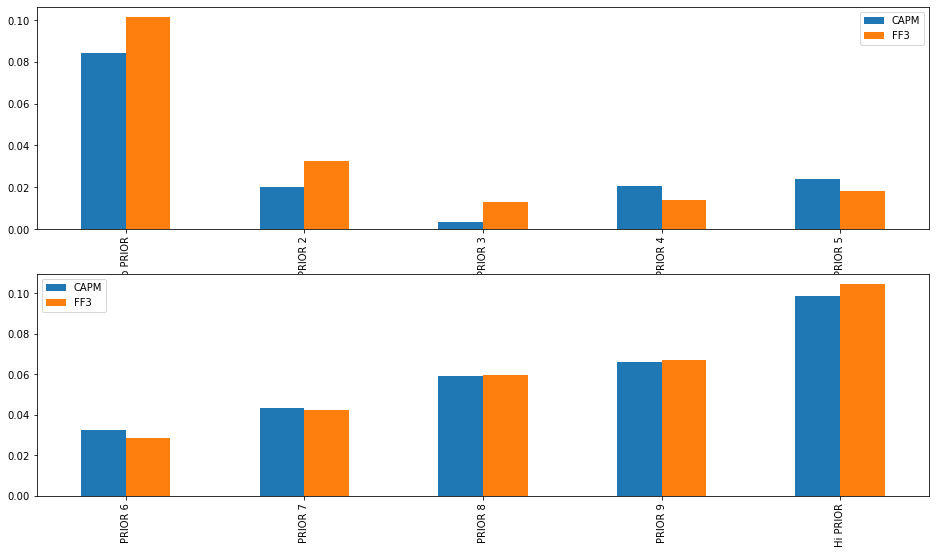

In [7]:
comp = pd.DataFrame({
    "CAPM": cm["mae"],
    "FF3": ff["mae"],
})


fig, axs = plt.subplots(2)
n = comp.shape[0] // 2

comp.iloc[:n].plot.bar(ax=axs[0])
comp.iloc[n:].plot.bar(ax=axs[1])

best = comp.sum().to_frame().idxmin()[0]

gt = {}

for c in comp.drop(best, axis=1).columns:
    gt[c] = comp[c] > comp[best]

gt = pd.DataFrame(gt).sum() / comp.shape[0]
print(f"The model that fits the best is {best}.\n")
print(f"Probability that {best} has a lower MSE than other factor models:")
print(gt)

plt.show()

# Correlations

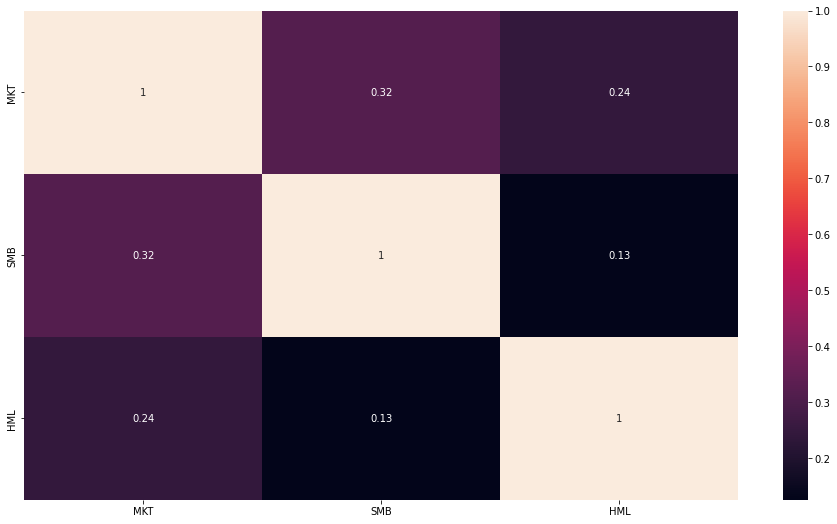

The pair with the HIGHEST correlation is ('MKT', 'SMB') at 0.31751005737457666
The pair with the LOWEST  correlation is ('SMB', 'HML') at 0.1252290824131139


In [8]:
def disp_corr(df):
    c = df.corr()
    sns.heatmap(c, annot=True); plt.show()
    
    cu = c.unstack().sort_values(ascending=False)
    cu = cu[c.shape[0]:] # There are c.shape[0] 1's in the corr matrix. Skip them.

    print(f"The pair with the HIGHEST correlation is {cu.idxmax()} at {cu.max()}")
    print(f"The pair with the LOWEST  correlation is {cu.idxmin()} at {cu.min()}")

disp_corr(fa)

# Compound Returns using a Mask

In [9]:
def compound_returns(df, year_mask=None):
    if not(year_mask):
        year_mask = (str(min(df.index).year), str(max(df.index).year))
    return (1+df.loc[year_mask[0]:year_mask[1], :]).cumprod()

compound_returns(fa)

,MKT,SMB,HML
Date,,,
1927-01-31,0.9994,0.9949,1.0473
1927-02-28,1.0412,0.9924,1.0815
1927-03-31,1.0425,0.9737,1.0539
1927-04-30,1.0473,0.9784,1.0613
1927-05-31,1.1043,0.9927,1.1142
...,...,...,...
2021-05-31,453.9470,6.2518,23.9914
2021-06-30,466.4306,6.3643,22.1297
2021-07-31,472.3542,6.1123,21.7424


# Total Returns to Excess

In [10]:
# de is total returns... subtracts risk free rate per column
excess = de.subtract(rf["RF"], axis=0)
excess

,Lo PRIOR,PRIOR 2,PRIOR 3,PRIOR 4,PRIOR 5,PRIOR 6,PRIOR 7,PRIOR 8,PRIOR 9,Hi PRIOR
Date,,,,,,,,,,
1927-01-31,-0.0357,-0.0471,0.0244,-0.0058,-0.0066,0.0072,0.0049,0.0011,-0.0066,-0.0049
1927-02-28,0.0727,0.0567,0.0799,0.0701,0.0296,0.0395,0.0257,0.0300,0.0394,0.0675
1927-03-31,-0.0353,-0.0331,-0.0422,-0.0507,-0.0078,-0.0272,0.0175,0.0011,0.0066,0.0517
1927-04-30,0.0179,-0.0345,-0.0272,-0.0162,0.0195,-0.0030,0.0180,-0.0084,0.0134,0.0524
1927-05-31,0.0242,0.0427,0.0565,0.0288,0.0606,0.0550,0.0466,0.0651,0.0781,0.0602
...,...,...,...,...,...,...,...,...,...,...
2021-05-31,-0.0004,0.0149,-0.0132,0.0141,0.0181,-0.0033,0.0203,0.0217,0.0190,-0.0478
2021-06-30,0.0231,0.0050,0.0168,0.0498,-0.0052,0.0434,0.0153,-0.0082,0.0218,0.0894
2021-07-31,-0.0031,0.0171,0.0341,0.0327,0.0155,0.0217,-0.0124,-0.0094,-0.0205,-0.0047


---

# MIDTERM 1 FUNCTIONS

---

In [11]:
breakpoint because this shit will break

SyntaxError: invalid syntax (<ipython-input-11-7fd5c0dcb55a>, line 1)

# Portstats

In [ ]:
def portstats(v, nper=1):
    """Arguments:
    v: pd.DataFrame containing rows of returns OR
    v: list-like portfolio returns
    nper: int for annualization
    """
    try:
        c = v.columns
    except AttributeError:
        c = ["Portfolio"]
    
    mu = v.mean() * nper
    sig = v.std() * np.sqrt(nper)
    vshaped = pd.DataFrame([mu, sig, mu / sig],
                           index=["mean", "std", "sharpe"], columns=c)
    return vshaped

def portstats_bm(v, bm, nper=1):
    """Arguments:
    v: pd.DataFrame containing rows of returns OR
    v: list-like portfolio returns
    bm: list-like benchmark
    nper: int for annualization
    """
    try:
        c = v.columns
    except AttributeError:
        c = ["Portfolio"]
    
    mu = v.mean() * nper
    sig = v.std() * np.sqrt(nper)
    
    alpha, beta, tr, ir = [], [], [], []
    for name, col in v.iteritems():
        res = sm.OLS(col, sm.add_constant(bm.values)).fit()
        
        alpha.append(res.params[0])
        beta.append(res.params[1])
        tr.append(mu[name] / res.params[1])
        ir.append(res.params[0] / res.resid.std() / np.sqrt(nper))
    
    alpha = pd.Series(alpha, index=c)
    beta = pd.Series(beta, index=c)
    tr = pd.Series(tr, index=c)
    ir = pd.Series(ir, index=c)
    
    ret = pd.DataFrame([mu, sig, mu / sig, alpha, beta, tr, ir],
                       index=["mean", "std", "sharpe", "alpha", "beta", "treynor", "info ratio"],
                       columns=c)
    return ret

ps = portstats(df, nper=12)
ps_bm = portstats_bm(df, df["HFRIFWI Index"], nper=12)
ps_bm

In [ ]:
def tailrisk(v, prob, logret=False, exkurt=True):
    """Arguments:
    v: pd.DataFrame containing columns of returns
    prob: float percentile for VaR
    excess: bool whether kurtosis of normal = 0 (True) or = 3 (False)
    """
    try:
        c = v.columns
    except AttributeError:
        c = ["Portfolio"]
    
    sk = v.skew()
    ku = v.kurtosis() - 3 * exkurt
    var = v.quantile(prob)
    
    cvar = []
    mask =  v < v.quantile(prob)
    for name, col in mask.iteritems():
        below = v[name].loc[col]
        cvar.append(sum(below)/len(below))
    
    cvar = pd.Series(cvar, index=c)
    
    if logret:
        cumu = np.exp(v.cumsum())
    else:
        cumu = (v+1).cumprod()
    from_peak = (cumu - cumu.cummax()) / cumu.cummax()

    pl, rl, dl = [], [], []
    trough = from_peak.idxmin()
    for col, date in trough.iteritems():
        peak = max(v.loc[(from_peak.index < date) & (from_peak[col] == 0), col].index)
        try:
            reco = min(v.loc[(from_peak.index > date) & (from_peak[col] == 0), col].index)
        except ValueError:
            reco = None
        
        if logret:
            # This may not work right at the moment...
            draw = np.log(cumu.loc[date,col] / cumu.loc[peak,col])
        else:
            draw = (cumu.loc[date,col] - cumu.loc[peak,col]) / cumu.loc[peak,col]

        pl.append(peak); rl.append(reco); dl.append(draw)

    dl = pd.Series(dl, index=c)
    pl = pd.Series(pl, index=c)
    rl = pd.Series(rl, index=c)
    
    ret = pd.DataFrame([sk, ku, var, cvar, dl],
                       index=["skew", "kurtosis", f"var_{prob}", f"cvar_{prob}", "drawdown"],
                       columns=c)
    dra = pd.DataFrame([pl, trough, rl],
                       index=["peak", "trough", "recovery"],
                       columns=c)
    ret = pd.concat([ret, dra], axis=0)
    
    return ret

tr = tailrisk(df, 0.05, logret=False)
tr

In [ ]:
def disp_corr(df):
    c = df.corr()
    sns.heatmap(c, annot=True); plt.show()
    
    cu = c.unstack().sort_values(ascending=False)
    cu = cu[c.shape[0]:] # There are c.shape[0] 1's in the corr matrix. Skip them.

    print(f"The pair with the HIGHEST correlation is {cu.idxmax()} at {cu.max()}")
    print(f"The pair with the LOWEST  correlation is {cu.idxmin()} at {cu.min()}")

disp_corr(df)

# Mean Variance Optimization

#### Tangency:
$$
\omega^{tan} = \biggl( \frac{1}{\mathbb{1}^T \Sigma^{-1} \tilde{\mu}} \biggr) \Sigma^{-1} \tilde{\mu} \\
$$

#### Target
$$\begin{aligned}
w^* &= \tilde{\mu}^p \biggl( \frac{1}{\tilde{\mu}^T \Sigma^{-1} \tilde{\mu}} \biggr) \Sigma^{-1} \tilde{\mu} \\
\end{aligned}$$

#### GMV
$$\begin{aligned}
w^* &= \biggl( \frac{1}{\mathbb{1}^T \Sigma^{-1} \mathbb{1}} \biggr) \Sigma^{-1} \mathbb{1} \\
\end{aligned}$$

In [ ]:
def mvtan(cov, mu):
    wt = np.linalg.inv(cov.values) @ mu
    return pd.Series(wt / sum(wt), index=cov.index)

def mvport(cov, mu, target):
    covinv = np.linalg.inv(cov)
    wmv = target / (mu.T @ covinv @ mu) * covinv @ mu
    return pd.Series(wmv, index=cov.index)

def mvgmv(cov):
    n = cov.shape[0]
    wv = np.linalg.inv(cov.values) @ np.ones(n)
    return pd.Series(wv / sum(wv), index=cov.index)

cov = df.cov()
wt = mvtan(cov, ps.T["mean"])
wt